<a href="https://colab.research.google.com/github/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [3]:
#!pip install tensorflow-gpu==2.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [4]:
#!pip install wandb -q

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.5.3
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christianhlohman (team-ninja). Use `wandb login --relogin` to force relogin


True

In [3]:
import os
import cv2
import numpy as np


import matplotlib.pyplot as plt
plt.gray()
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [4]:
## Cifar 10 Dataset
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

data = np.load("C:\\Users\\Blomst\\nn_dataset_400x400x6_random_200k.npy")

x_test  = data[0][160000:,:]
x_train = data[0][:160000,:]
y_test  = data[1][160000:,:]
y_train = data[1][:160000,:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(y_train.shape[0], 'actual train samples')
print(y_test.shape[0], 'actual test samples')

x_train shape: (160000, 32, 32, 1)
160000 train samples
19012 test samples
160000 actual train samples
19012 actual test samples


#### Visualization of Cifar 10

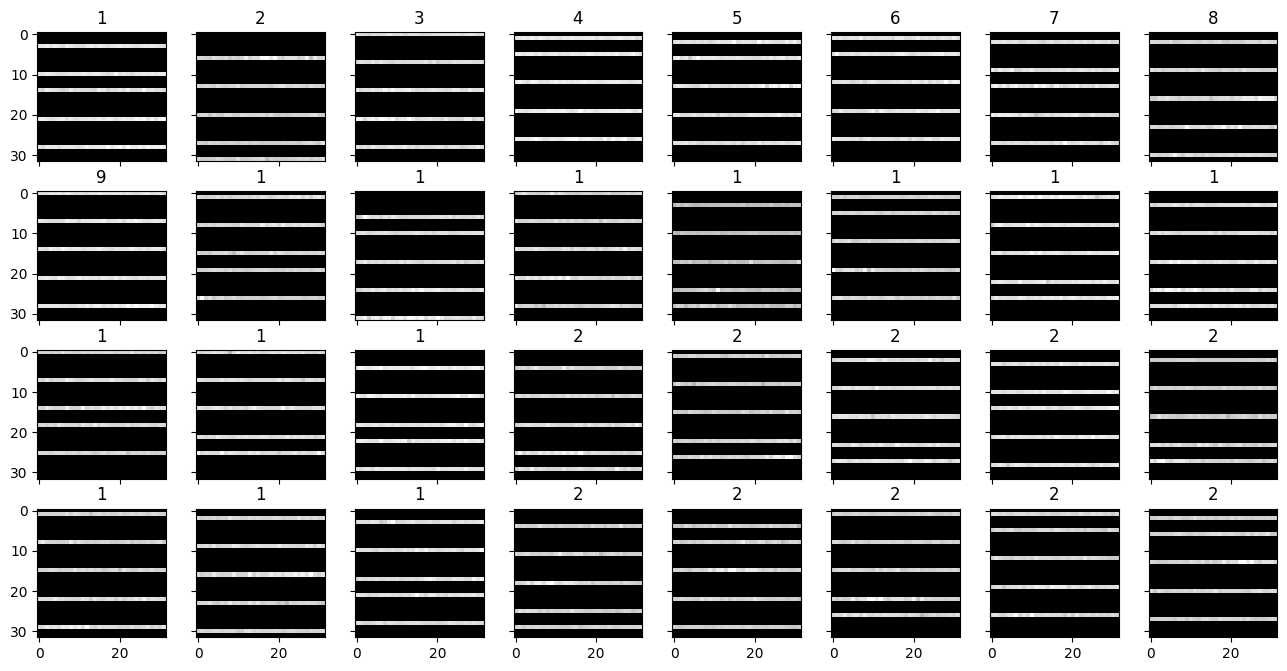

In [5]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","17","18","19","20","21","22","23","24"]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image.astype(np.uint8))
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [6]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=1, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()
# 
  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      
      X_batch[i,] = self.X[idx]/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, y_train)
testgen = createAugment(x_test, y_test, shuffle=False)

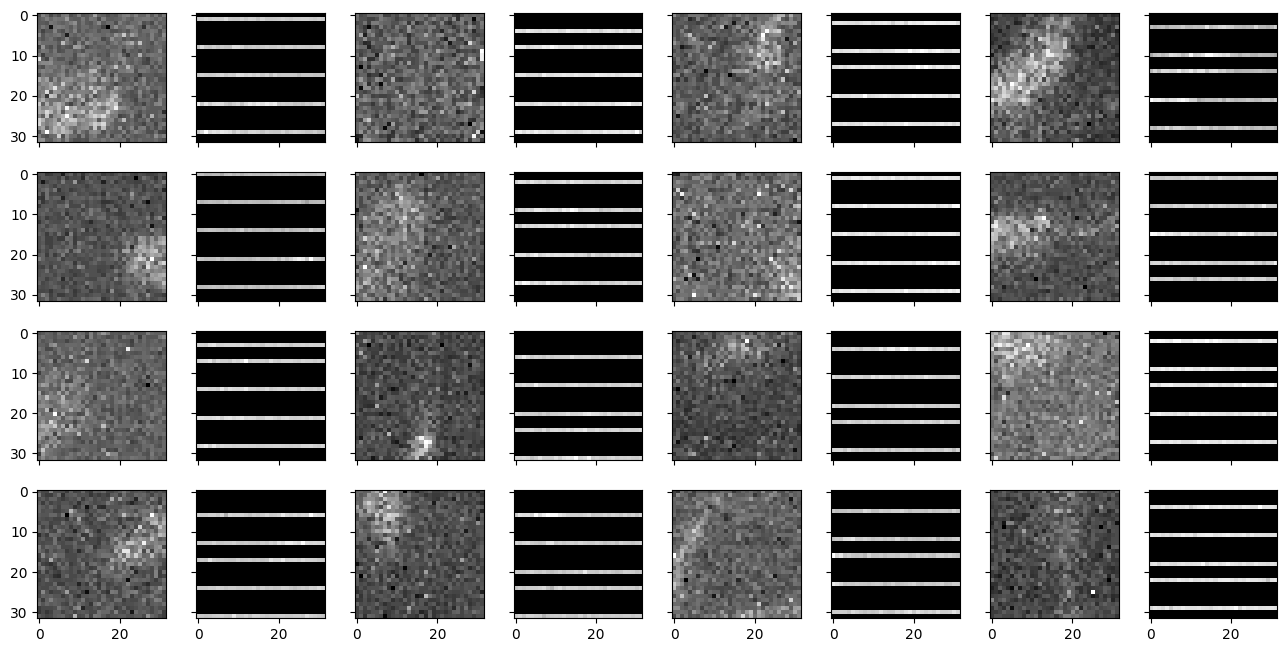

In [8]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [9]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [10]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,1)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    #conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    #conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', pool3, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [13]:
!pip install pydot

In [11]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
#keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

# Train

In [12]:

wandb.init(entity='christianhlohman', project="image-impainting")

wandb: Currently logged in as: christianhlohman. Use `wandb login --relogin` to force relogin


In [13]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        
        sample_images, sample_labels = testgen[sample_idx]  
        
        images = []
        labels = []
        predictions = []
        
        for i in range(32):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

        wandb.log({"images": [wandb.Image(image)
                              for image in images]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})

In [14]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=6, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=False,
          callbacks=[WandbCallback(),
                     PredictionLogger()])
                     
                    

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/6
5000/5000 [==============================] - 60s 11ms/step - loss: 0.0109 - dice_coef: 0.4106 - val_loss: 0.0108 - val_dice_coef: 0.4119
INFO:tensorflow:Assets written to: c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best)... Done. 0.1s


Epoch 2/6
5000/5000 [==============================] - 58s 12ms/step - loss: 0.0103 - dice_coef: 0.4107 - val_loss: 0.0107 - val_dice_coef: 0.4126
INFO:tensorflow:Assets written to: c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best)... Done. 0.0s


Epoch 3/6
5000/5000 [==============================] - 57s 11ms/step - loss: 0.0102 - dice_coef: 0.4107 - val_loss: 0.0106 - val_dice_coef: 0.4122
INFO:tensorflow:Assets written to: c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best)... Done. 0.0s


Epoch 4/6
5000/5000 [==============================] - 57s 11ms/step - loss: 0.0102 - dice_coef: 0.4107 - val_loss: 0.0108 - val_dice_coef: 0.4119
Epoch 5/6
5000/5000 [==============================] - 57s 11ms/step - loss: 0.0102 - dice_coef: 0.4107 - val_loss: 0.0108 - val_dice_coef: 0.4129
Epoch 6/6
5000/5000 [==============================] - 57s 11ms/step - loss: 0.0102 - dice_coef: 0.4107 - val_loss: 0.0106 - val_dice_coef: 0.4123
INFO:tensorflow:Assets written to: c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Blomst\Documents\wandb\run-20230503_083726-qxbg9f81\files\model-best)... Done. 0.0s


# Testing on images

In [54]:
## Examples
rows = 32
sample_idx = 54
sample_images, sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  smooth_image = smooth(impainted_image)
  
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

SyntaxError: invalid syntax (2552093090.py, line 15)

Creating new dataset, for complemete noise reduction: 

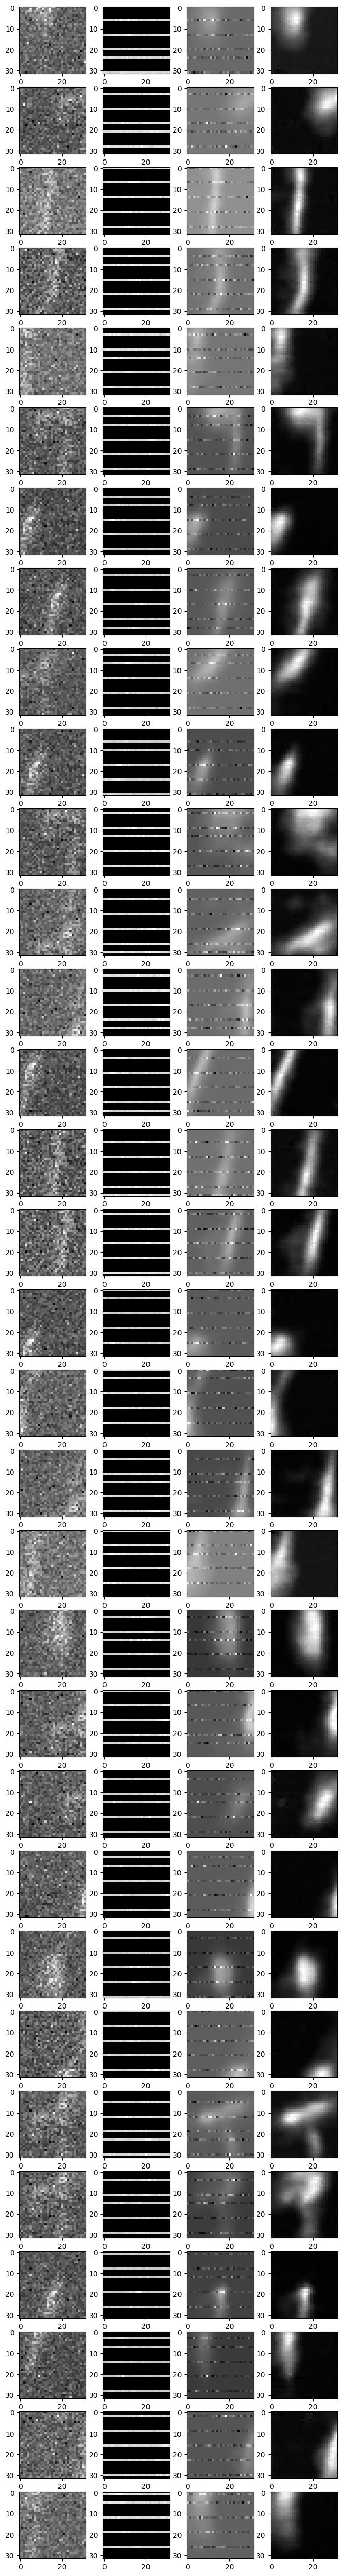

In [15]:
def contains(lst, n):
    for elem in lst:
        if(elem == n):
            return True
    return False

def set_rows_zero(patch, rows):
   # new = np.ndarray.copy(patch)
    for i in range(len(patch[0])):
        if(contains(rows, i)):
            for k in range(len(patch[0][0])):
                patch[0][i][k][0] = 0
    return 1

def get_removed_rows(patch):
    lst = []
    c=0
    for row in patch:
        if row[0][0] != 0:
            lst.append(c)
        c=c+1
    return lst

def convolution(x, i, j):    
    if  (i==0 and j==0):
        return x[0,i+1,j,0]*1/2 + x[0,i+1,j+1,0]*1/2
    elif(i == 31 and j == 31):
        return x[0,i-1,j,0]*1/2 + x[0,i-1,j-1,0]*1/2
    elif(i == 31 and j == 0):
        return x[0,i-1,j,0]*1/2 + x[0,i-1,j+1,0]*1/2
    elif(i == 0 and j == 31):
        return x[0,i+1,j,0]*1/2 + x[0,i+1,j-1,0]*1/2
    elif(i==0):
        return x[0,i+1,j,0]*1/3 + x[0,i+1,j-1,0]*1/3 + x[0,i+1,j+1,0]*1/3
    elif(j==0):
        return x[0,i-1,j,0]*1/3 + x[0,i+1,j,0]*1/3 + x[0,i-1,j+1,0]*1/6 + x[0,i+1,j+1,0]*1/6
    elif(i == 31):
        return x[0,i-1,j,0]*1/3 + x[0,i-1,j+1,0]*1/3 + x[0,i-1,j-1,0]*1/3
    elif(j == 31):
        return x[0,i-1,j,0]*1/3 + x[0,i+1,j,0]*1/3 + x[0,i+1,j-1,0]*1/6 + x[0,i-1,j-1,0]*1/6
    else:
        return x[0,i-1,j,0]*1/6 + x[0,i+1,j,0]*1/6 + x[0,i+1,j-1,0]*1/6 + x[0,i-1,j+1,0]*1/6 + x[0,i+1,j+1,0]*1/6 + x[0,i-1,j-1,0]*1/6

def convulotion_at_0(input):
    x = np.ndarray.copy(input)
    for i in range(len(x[0])):
        for j in range(len(x[0][i])):
            if(x[0][i][j][0] == 0):
                x[0][i][j][0] = convolution(x,i,j)
    return x


def smooth(org, impainted_image):
    new = np.ndarray.copy(impainted_image)
    remove = np.ndarray.copy(new)
    not_removed = get_removed_rows(org)
    set_rows_zero(remove, not_removed)
    smooth = convulotion_at_0(remove)
    return remove, smooth


## Examples
rows = 32
sample_idx = 50
sample_images, sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    removed, smooth_image = smooth(sample_images[i],impainted_image)

    #print(sample_images[i][2][4][0])
    #print(impainted_image[0][2][4][0])
    #print(smooth_image[0][2][4][0])
    #print()

    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
    #axs[i][3].imshow(removed.reshape(removed.shape[1:]))
    axs[i][3].imshow(smooth_image.reshape(smooth_image.shape[1:]))

plt.show()

Recreate full image

In [ ]:
!pip install scikit-image

In [5]:
def convolution(x, i, j):
    I = len(x)-1
    J = len(x[0])-1
    if  (i==0 and j==0):
        return x[i+1,j]*1/2 + x[i+1,j+1]*1/2
    elif(i == I and j == J):
        return x[i-1,j]*1/2 + x[i-1,j-1]*1/2
    elif(i == I and j == 0):
        return x[i-1,j]*1/2 + x[i-1,j+1]*1/2
    elif(i == 0 and j == J):
        return x[i+1,j]*1/2 + x[i+1,j-1]*1/2
    elif(i==0):
        return x[i+1,j]*1/3 + x[i+1,j-1]*1/3 + x[i+1,j+1]*1/3
    elif(j==0):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6
    elif(i == I):
        return x[i-1,j]*1/3 + x[i-1,j+1]*1/3 + x[i-1,j-1]*1/3
    elif(j == J):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i+1,j-1]*1/6 + x[i-1,j-1]*1/6
    else:
        return x[i-1,j]*1/6 + x[i+1,j]*1/6 + x[i+1,j-1]*1/6 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6 + x[i-1,j-1]*1/6
    


def convolve_nth(x, nth, first):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if((i-first)%nth == 0):
                x[i,j] = convolution(x, i, j)
    return x


In [20]:
from PIL import Image
from skimage import io
from tifffile import imwrite


#model = keras.models.load_model('C:\\Users\\Blomst\\Documents\\wandb\\run-20230502_123711-z5j53qbx\\files\\model-best.h5', custom_objects={"metric": dice_coef})

#full = np.load("C:\\Users\\Blomst\\recreate.npy")


X = np.load("C:\\Users\\Blomst\\z\\1\\797.npy")

#org = Image.fromarray(Z)
#org = org.convert('RGB')
#org.show(i)

def formatter(patch):
    x,y = patch.shape
    new = np.ndarray((x,y,1))
    for i in range(len(patch)):
        for j in range(len(patch[i])):
            number = patch[i][j]
            new[i][j] = number
    return new



sperm_path ='C:\\Users\\Blomst\\sperm_0p2_70hz_6t_00064.BTF'    # Dataset 1 - 400x400x6
sperm_path2 ='C:\\Users\\Blomst\\sperm_0p2_40hz_12t_00068.BTF'  # Dataset 0 - 348x348x12

def find_min_and_max(data):
    vector = data.reshape(-1)
    min=255
    max=0
    for elem in vector:
        if(min > elem): min = elem
        if(max < elem): max = elem
    return (min, max)

def predection_to_image(prediction):
    _, x,y,_ = prediction.shape
    new = np.ndarray((x,y))
    for i in range(x):
        for j in range(y):
            new[i,j] = prediction[0,i,j,0]
    return new


window_size = 32


results = []
for time in range(len(X)):
    
    Z = X[time]
    result = []
    for layer in range(len(Z)):

        one  = time*layer+layer
        two  = len(Z)*len(X)
        print(one, "/" , two )
        full = formatter(Z[layer])
        w,h, _ = full.shape
        #print(w,",",h)  
        reconstruction = np.zeros((w,h))
        count = 0
        for i in range(0,w-window_size+1):
            #print(count,"/", w-window_size+1)
            count = count + 1
            for j in range(0,h-window_size+1):
                if(not(j <= 3 or j >= h-window_size)):
                    if(not(i <= 3 or i >= w-window_size)):
                        if(not(i % 4 == 0)):
                            continue
                        if(not(j % 4 == 0)):
                            continue
                patch = full[i:i + window_size, j:j + window_size]/255 
                impainting = model.predict(patch.reshape((1,)+patch.shape))
                image = predection_to_image(impainting)
                if(i == 0 and j==0):                            reconstruction[:16, :16] = image[:16, :16]
                elif(i == w-window_size and j==h-window_size):  reconstruction[i+15:, j+15:] = image[15:,15:]
                elif(i == w-window_size and j==0):              reconstruction[i+15:, :16] = image[15:,:16]
                elif(i == 0 and j==h-window_size):              reconstruction[:16, j+15:] = image[:16, 15:]
                elif(i==w-window_size):                         reconstruction[i+15:, j+15] = image[15:,15]
                elif(j==h-window_size):                         reconstruction[i+15, j+15:] = image[15,15:]
                elif(i==0):                                     reconstruction[:16, j+15] = image[:16,15]
                elif(j==0):                                     reconstruction[i+15, :16] = image[15,:16]
                else:                                           reconstruction[i+15:i+19, j+15:j+19]  = image[15:19,15:19]
                #else:                                           reconstruction[i+15, j+15]  = image[15,15]
                #reconstruction[i:i + window_size, j:j + window_size]  = image
            
            #img2 = Image.fromarray(reconstruction*255)
            #img2 = img2.convert('RGB')
            #img2.save("c:\\users\\blomst\\reconstruction.png")


        smooth = convolve_nth(reconstruction*255, 4, 1)
        img2 = Image.fromarray(smooth)
        img2 = img2.convert('RGB')

        path = "c:\\users\\blomst\\smooth\\" + str(time) + "_" + str(layer) + ".png"
        img2.save(path)
        result.append(smooth)
    results.append(result)
    print(np.shape(results))

out = np.array(results)

np.save("c:\\users\\blomst\\400x400.npy", out)
imwrite('c:\\users\\blomst\\documents\\400x400.tif', out, imagej=True)


for image in result:
    img2 = Image.fromarray(image)
    img2 = img2.convert('RGB')
    img2.show("c:\\users\\blomst\\reconstruction.png")

0 / 747
1 / 747
2 / 747
3 / 747
4 / 747
5 / 747
6 / 747
7 / 747
8 / 747
9 / 747


KeyboardInterrupt: 

In [17]:
def convolution(x, i, j):
    I = len(x)-1
    J = len(x[0])-1
    if  (i==0 and j==0):
        return x[i+1,j]*1/2 + x[i+1,j+1]*1/2
    elif(i == I and j == J):
        return x[i-1,j]*1/2 + x[i-1,j-1]*1/2
    elif(i == I and j == 0):
        return x[i-1,j]*1/2 + x[i-1,j+1]*1/2
    elif(i == 0 and j == J):
        return x[i+1,j]*1/2 + x[i+1,j-1]*1/2
    elif(i==0):
        return x[i+1,j]*1/3 + x[i+1,j-1]*1/3 + x[i+1,j+1]*1/3
    elif(j==0):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6
    elif(i == I):
        return x[i-1,j]*1/3 + x[i-1,j+1]*1/3 + x[i-1,j-1]*1/3
    elif(j == J):
        return x[i-1,j]*1/3 + x[i+1,j]*1/3 + x[i+1,j-1]*1/6 + x[i-1,j-1]*1/6
    else:
        return x[i-1,j]*1/6 + x[i+1,j]*1/6 + x[i+1,j-1]*1/6 + x[i-1,j+1]*1/6 + x[i+1,j+1]*1/6 + x[i-1,j-1]*1/6
    

recon = io.imread('c:\\Users\\Blomst\\reconstruction.png', as_gray=True)

print(recon.shape)


def convolve_nth(x, nth, first):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if((i-first)%nth == 0):
                x[i,j] = convolution(x, i, j)
    return x


(48, 348)


In [65]:
print(model.layers[1].trainable_weights)


images = np.array(model.layers[2].trainable_weights[0])
for i in range(len(images)):
    for j in range(len(images[0])):
        new = images[i][j]* 255
        img = Image.fromarray(new)
        img = img.convert('RGB')
        #img.show()


[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 0.11813776,  0.10983694,  0.11528761, -0.09187465,
           0.03923138,  0.05359097, -0.11937528,  0.00928103,
           0.12567617,  0.06077294, -0.12187813, -0.10913693,
           0.07805745, -0.0119427 ,  0.10424073,  0.0803111 ,
           0.07533234, -0.09959102, -0.02578115, -0.01212658,
          -0.08344354,  0.03162855,  0.04608655, -0.10198569,
          -0.06047863,  0.0657936 ,  0.00232332, -0.02261502,
           0.10150604,  0.07142426,  0.06312734, -0.02506287]],

        [[ 0.06895556,  0.07829887, -0.02924256, -0.18048128,
           0.081608  , -0.07686416, -0.00976755,  0.09303738,
           0.03373125,  0.07551552, -0.12138304, -0.01342481,
          -0.16760804, -0.07890268, -0.04915887,  0.0227835 ,
           0.06990504,  0.04700232, -0.05343573, -0.11353937,
          -0.00985143,  0.09002919,  0.05016886, -0.13049039,
           0.21975243,  0.23142764, -0.01345813, -0.082